<a href="https://colab.research.google.com/github/tenglexin/LunarLander-v3/blob/main/1Assignment_TengLeXin_MRT234013.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gymnasium[box2d]
!pip install stable-baselines3
!pip install matplotlib pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 74.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.0/188.0 kB 2.7 MB/s eta 0:00:00


In [2]:
import gymnasium as gym

env = gym.make("LunarLander-v3", render_mode="human")

In [3]:
print("Observation Space:", env.observation_space)
print("Action Space:", env.action_space)

Observation Space: Box([ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ], [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ], (8,), float32)
Action Space: Discrete(4)


In [4]:
for episode in range(2):
    obs, _ = env.reset()
    done = False
    total_reward = 0

    while not done:
        action = env.action_space.sample()
        obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        total_reward += reward

    print(f"Random Episode {episode+1} Total Reward: {total_reward}")

env.close()

Random Episode 1 Total Reward: -329.3281423690322
Random Episode 2 Total Reward: -376.5560727259829


In [5]:
from stable_baselines3.common.monitor import Monitor
from stable_baselines3 import DQN, A2C, PPO
from stable_baselines3.common.env_util import make_vec_env
import os

ENV_NAME = "LunarLander-v3"
TIMESTEPS = 200_000

os.makedirs("models", exist_ok=True)
for name in ["DQN", "A2C", "PPO"]:
    os.makedirs(f"logs/{name}", exist_ok=True)

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [6]:
def train_model(algorithm, name):
    env = make_vec_env(
        ENV_NAME,
        n_envs=1,
        monitor_dir=f"logs/{name}"
    )
    model = algorithm("MlpPolicy", env, verbose=1)
    model.learn(total_timesteps=TIMESTEPS)
    model.save(f"models/{name}_lunarlander")
    env.close()
    return model

In [7]:
dqn = train_model(DQN, "DQN")
a2c = train_model(A2C, "A2C")
ppo = train_model(PPO, "PPO")

Using cpu device
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 92       |
|    ep_rew_mean      | -173     |
|    exploration_rate | 0.983    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 785      |
|    time_elapsed     | 0        |
|    total_timesteps  | 368      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.81     |
|    n_updates        | 66       |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Streaming output truncated to the last 5000 lines.
|    iterations         | 22700    |
|    time_elapsed       | 308      |
|    total_timesteps    | 113500   |
| train/                |          |
|    entropy_loss       | -0.434   |
|    explained_variance | 0.00521  |
|    learning_rate      | 0.0007   |
|    n_updates          | 22699    |
|    policy_loss        | 0.606    |
|    value_loss         | 8.23     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 326      |
|    ep_rew_mean        | 9.99     |
| time/                 |          |
|    fps                | 368      |
|    iterations         | 22800    |
|    time_elapsed       | 309      |
|    total_timesteps    | 114000   |
| train/                |          |
|    entropy_loss       | -0.305   |
|    explained_variance | 0.947    |
|    learning_rate      | 0.0007   |
|    n_updates          | 22799    |
|    policy_loss        

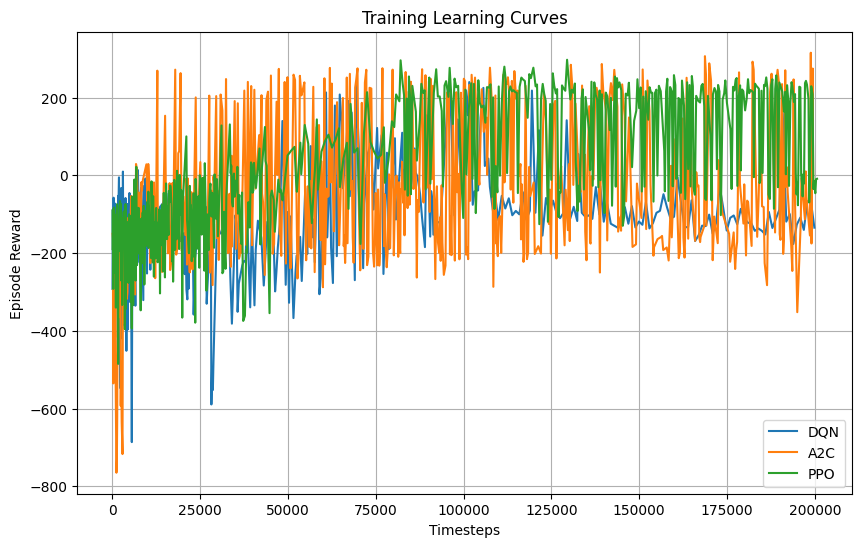

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [8]:
from stable_baselines3.common.results_plotter import load_results, ts2xy
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

for name in ["DQN", "A2C", "PPO"]:
    x, y = ts2xy(load_results(f"logs/{name}"), "timesteps")
    plt.plot(x, y, label=name)

plt.xlabel("Timesteps")
plt.ylabel("Episode Reward")
plt.title("Training Learning Curves")
plt.legend()
plt.grid(True)
plt.show()

In [9]:
import numpy as np

def evaluate_model(model, env, episodes=30):
    rewards = []

    for _ in range(episodes):
        obs, _ = env.reset()
        done = False
        total_reward = 0

        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward

        rewards.append(total_reward)

    return np.array(rewards)

In [10]:
eval_env = gym.make("LunarLander-v3")

dqn = DQN.load("models/DQN_lunarlander")
a2c = A2C.load("models/A2C_lunarlander")
ppo = PPO.load("models/PPO_lunarlander")

results = {
    "DQN": evaluate_model(dqn, eval_env),
    "A2C": evaluate_model(a2c, eval_env),
    "PPO": evaluate_model(ppo, eval_env)
}

In [11]:
import pandas as pd

summary = pd.DataFrame({
    "Algorithm": results.keys(),
    "Average Reward": [np.mean(r) for r in results.values()],
    "Reward Variance": [np.var(r) for r in results.values()]
})

summary

,Algorithm,Average Reward,Reward Variance
0,DQN,-110.546427,1213.744011
1,A2C,29.546868,23596.894914
2,PPO,131.865436,12677.850193


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


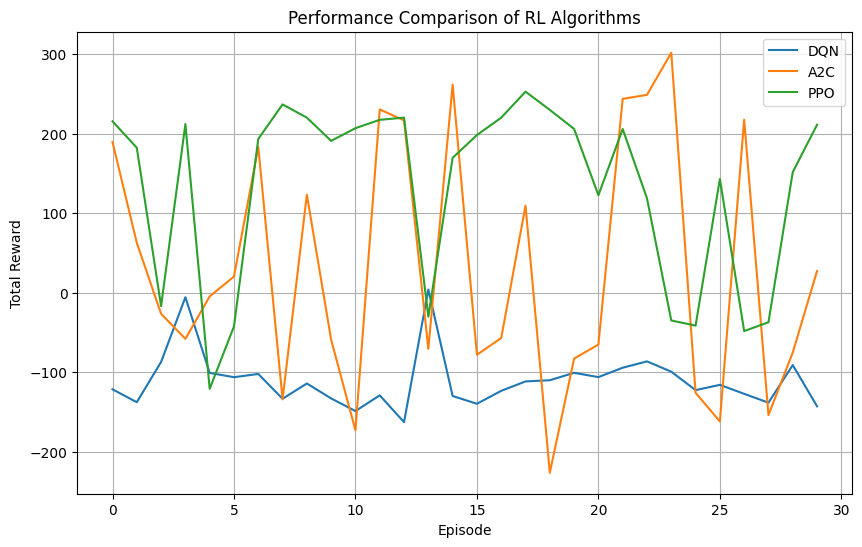

In [12]:
plt.figure(figsize=(10,6))

for name, rewards in results.items():
    plt.plot(rewards, label=name)

plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Performance Comparison of RL Algorithms")
plt.legend()
plt.grid(True)
plt.show()

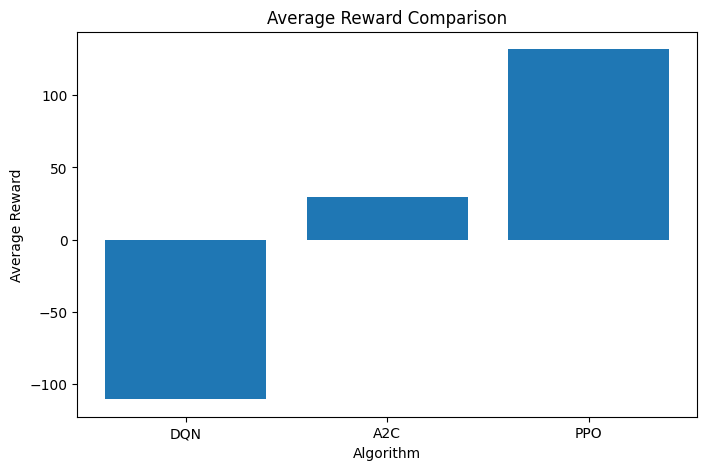

In [13]:
plt.figure(figsize=(8,5))
plt.bar(summary["Algorithm"], summary["Average Reward"])
plt.xlabel("Algorithm")
plt.ylabel("Average Reward")
plt.title("Average Reward Comparison")
plt.show()

In [14]:
import os

video_path = "/content/drive/MyDrive/Colab Notebooks/MRTB2153-50_Advanced AI_TengLeXin/Assignment/LunarLanderVideos"
os.makedirs(video_path, exist_ok=True)

In [15]:
from gymnasium.wrappers import RecordVideo
import gymnasium as gym

video_env = RecordVideo(
    gym.make("LunarLander-v3", render_mode="rgb_array"),
    video_folder=video_path,
    episode_trigger=lambda e: True
)

obs, _ = video_env.reset()
done = False

while not done:
    action, _ = ppo.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, _ = video_env.step(action)
    done = terminated or truncated

video_env.close()

/usr/local/lib/python3.12/dist-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /content/drive/MyDrive/Colab Notebooks/MRTB2153-50_Advanced AI_TengLeXin/Assignment/LunarLanderVideos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/usr/local/lib/python3.12/dist-packages/moviepy/config_defaults.py:47: SyntaxWarning: invalid escape sequence '\P'
  IMAGEMAGICK_BINARY = r"C:\Program Files\ImageMagick-6.8.8-Q16\magick.exe"
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [17]:
import os
os.listdir(video_path)

['rl-video-episode-0.mp4']